# Pretrain LSTM Network using Simulated Data
### target is validation loss, best model is saved, architecture given by 'SimulatedPretrainedModelTuner.ipynb'

Epoch 1/2000
141/141 [==============================] - ETA: 0s - loss: -1.2856

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 35s 225ms/step - loss: -1.2856 - val_loss: -1.9603
Epoch 2/2000
141/141 [==============================] - ETA: 0s - loss: -2.4027

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 221ms/step - loss: -2.4027 - val_loss: -2.7423
Epoch 3/2000
141/141 [==============================] - ETA: 0s - loss: -2.9056

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 220ms/step - loss: -2.9056 - val_loss: -3.2143
Epoch 4/2000
141/141 [==============================] - ETA: 0s - loss: -3.1930

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 220ms/step - loss: -3.1930 - val_loss: -3.3652
Epoch 5/2000
141/141 [==============================] - ETA: 0s - loss: -3.4060

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -3.4060 - val_loss: -3.5936
Epoch 6/2000
141/141 [==============================] - ETA: 0s - loss: -3.5213

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -3.5213 - val_loss: -3.7293
Epoch 7/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.6314 - val_loss: -3.7067
Epoch 8/2000
141/141 [==============================] - ETA: 0s - loss: -3.5995

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -3.5995 - val_loss: -3.8897
Epoch 9/2000
141/141 [==============================] - 24s 170ms/step - loss: -3.5708 - val_loss: -3.7288
Epoch 10/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.7780 - val_loss: -3.7647
Epoch 11/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.6889 - val_loss: -3.7951
Epoch 12/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.9149 - val_loss: -3.4662
Epoch 13/2000
141/141 [==============================] - 24s 170ms/step - loss: -3.9678 - val_loss: -3.7405
Epoch 14/2000
141/141 [==============================] - ETA: 0s - loss: -4.0485

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 220ms/step - loss: -4.0485 - val_loss: -4.1569
Epoch 15/2000
141/141 [==============================] - 24s 172ms/step - loss: -3.8295 - val_loss: -3.9089
Epoch 16/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.0528 - val_loss: -4.1513
Epoch 17/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.8718 - val_loss: -4.1262
Epoch 18/2000
141/141 [==============================] - 24s 173ms/step - loss: -3.9363 - val_loss: -4.0498
Epoch 19/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.1373 - val_loss: -4.0439
Epoch 20/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.1525 - val_loss: 3.8767
Epoch 21/2000
141/141 [==============================] - ETA: 0s - loss: -3.8711

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -3.8711 - val_loss: -4.1893
Epoch 22/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.1333 - val_loss: -4.1467
Epoch 23/2000
141/141 [==============================] - ETA: 0s - loss: -4.2021

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -4.2021 - val_loss: -4.2229
Epoch 24/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.1638 - val_loss: -4.1924
Epoch 25/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.0220 - val_loss: -3.7603
Epoch 26/2000
141/141 [==============================] - 24s 170ms/step - loss: -4.2942 - val_loss: -4.0685
Epoch 27/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.2302 - val_loss: -3.8273
Epoch 28/2000
141/141 [==============================] - ETA: 0s - loss: -4.3341

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 223ms/step - loss: -4.3341 - val_loss: -4.3156
Epoch 29/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.2768 - val_loss: -4.0625
Epoch 30/2000
141/141 [==============================] - 24s 172ms/step - loss: -3.3251 - val_loss: -3.1903
Epoch 31/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.2669 - val_loss: -4.0205
Epoch 32/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.6639 - val_loss: -4.1745
Epoch 33/2000
141/141 [==============================] - 24s 172ms/step - loss: -3.7830 - val_loss: -4.2356
Epoch 34/2000
141/141 [==============================] - 24s 172ms/step - loss: -3.9552 - val_loss: -4.0689
Epoch 35/2000
141/141 [==============================] - 24s 170ms/step - loss: -4.0606 - val_loss: -2.4403
Epoch 36/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.0654 - val_loss: -3.2099
Epoch 37/2000
141/141 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 221ms/step - loss: -4.2757 - val_loss: -4.4940
Epoch 40/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.1838 - val_loss: -4.4077
Epoch 41/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.2333 - val_loss: -4.4090
Epoch 42/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.2231 - val_loss: -4.3750
Epoch 43/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.1833 - val_loss: -4.4731
Epoch 44/2000
141/141 [==============================] - 24s 171ms/step - loss: -3.8990 - val_loss: -4.3519
Epoch 45/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.1447 - val_loss: -4.1284
Epoch 46/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.3041 - val_loss: -4.4126
Epoch 47/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.2382 - val_loss: -3.4391
Epoch 48/2000
141/141 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -4.3916 - val_loss: -4.4941
Epoch 55/2000
141/141 [==============================] - ETA: 0s - loss: -4.3677

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -4.3677 - val_loss: -4.4970
Epoch 56/2000
141/141 [==============================] - ETA: 0s - loss: -4.5019

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -4.5019 - val_loss: -4.5937
Epoch 57/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.5015 - val_loss: -3.7200
Epoch 58/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.4737 - val_loss: -4.4495
Epoch 59/2000
141/141 [==============================] - 24s 170ms/step - loss: -4.5327 - val_loss: -4.3529
Epoch 60/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.5608 - val_loss: -4.5238
Epoch 61/2000
141/141 [==============================] - 24s 172ms/step - loss: -3.9027 - val_loss: -4.3334
Epoch 62/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.2240 - val_loss: -4.4461
Epoch 63/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.3248 - val_loss: -4.0499
Epoch 64/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.2223 - val_loss: -4.5581
Epoch 65/2000
141/141 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 223ms/step - loss: -4.4570 - val_loss: -4.7066
Epoch 69/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.3443 - val_loss: -4.4302
Epoch 70/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.5057 - val_loss: -4.3126
Epoch 71/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.4471 - val_loss: -4.6453
Epoch 72/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.4788 - val_loss: -3.3527
Epoch 73/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.5746 - val_loss: -4.6466
Epoch 74/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.4932 - val_loss: -4.4144
Epoch 75/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.4615 - val_loss: -4.0878
Epoch 76/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.5492 - val_loss: -4.4360
Epoch 77/2000
141/141 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 224ms/step - loss: -4.5979 - val_loss: -4.7439
Epoch 86/2000
141/141 [==============================] - 24s 170ms/step - loss: -4.5753 - val_loss: -4.4491
Epoch 87/2000
141/141 [==============================] - 24s 174ms/step - loss: -4.6305 - val_loss: -4.6968
Epoch 88/2000
141/141 [==============================] - 24s 174ms/step - loss: -4.5442 - val_loss: -4.5721
Epoch 89/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.6859 - val_loss: -4.2874
Epoch 90/2000
141/141 [==============================] - 25s 174ms/step - loss: -3.8585 - val_loss: -4.3433
Epoch 91/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.3791 - val_loss: -4.6376
Epoch 92/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.2976 - val_loss: -4.6679
Epoch 93/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.4451 - val_loss: -4.6460
Epoch 94/2000
141/141 [===================

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -4.6317 - val_loss: -4.7542
Epoch 109/2000
141/141 [==============================] - ETA: 0s - loss: -4.7303

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -4.7303 - val_loss: -4.7570
Epoch 110/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.4850 - val_loss: -4.4792
Epoch 111/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.5016 - val_loss: -4.4982
Epoch 112/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.6337 - val_loss: -4.6736
Epoch 113/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.6716 - val_loss: -4.3918
Epoch 114/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.6268 - val_loss: -4.6784
Epoch 115/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.6847 - val_loss: -4.6721
Epoch 116/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.6505 - val_loss: -4.4927
Epoch 117/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.6730 - val_loss: -4.6593
Epoch 118/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 222ms/step - loss: -4.7760 - val_loss: -4.7946
Epoch 121/2000
141/141 [==============================] - ETA: 0s - loss: -4.7195

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -4.7195 - val_loss: -4.8536
Epoch 122/2000
141/141 [==============================] - 24s 174ms/step - loss: -4.7504 - val_loss: -4.6783
Epoch 123/2000
141/141 [==============================] - 24s 171ms/step - loss: -4.7841 - val_loss: -2.1693
Epoch 124/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.7502 - val_loss: -4.7193
Epoch 125/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.6352 - val_loss: -4.5746
Epoch 126/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7564 - val_loss: -4.5858
Epoch 127/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7981 - val_loss: -4.8348
Epoch 128/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.7241 - val_loss: -3.8640
Epoch 129/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.2501 - val_loss: -4.1909
Epoch 130/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -4.7074 - val_loss: -4.8658
Epoch 166/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7237 - val_loss: -2.9502
Epoch 167/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.7361 - val_loss: -2.9254
Epoch 168/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.7364 - val_loss: -4.7705
Epoch 169/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.4198 - val_loss: -4.4861
Epoch 170/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.7672 - val_loss: -4.6560
Epoch 171/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7975 - val_loss: -4.7311
Epoch 172/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.7663 - val_loss: -4.5889
Epoch 173/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.6318 - val_loss: -4.7666
Epoch 174/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -4.8473 - val_loss: -4.8887
Epoch 177/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.6955 - val_loss: -4.7441
Epoch 178/2000
141/141 [==============================] - ETA: 0s - loss: -4.7935

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 224ms/step - loss: -4.7935 - val_loss: -4.9262
Epoch 179/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.7436 - val_loss: -4.8334
Epoch 180/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.8811 - val_loss: -4.7036
Epoch 181/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7628 - val_loss: -4.6410
Epoch 182/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.8357 - val_loss: -4.9198
Epoch 183/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7540 - val_loss: -4.8115
Epoch 184/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.8614 - val_loss: -4.8867
Epoch 185/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7785 - val_loss: -4.8118
Epoch 186/2000
141/141 [==============================] - 25s 178ms/step - loss: -4.7516 - val_loss: -4.7460
Epoch 187/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -4.9598 - val_loss: -4.9422
Epoch 207/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.8155 - val_loss: -4.9391
Epoch 208/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.8601 - val_loss: -4.2320
Epoch 209/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.8780 - val_loss: -4.7578
Epoch 210/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7785 - val_loss: -4.5586
Epoch 211/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.8980 - val_loss: -4.2118
Epoch 212/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.9298 - val_loss: -3.9409
Epoch 213/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.9699 - val_loss: -0.8963
Epoch 214/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.4203 - val_loss: -4.2666
Epoch 215/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -4.9208 - val_loss: -4.9457
Epoch 217/2000
141/141 [==============================] - 24s 174ms/step - loss: -4.6438 - val_loss: -4.3368
Epoch 218/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.8297 - val_loss: -4.7988
Epoch 219/2000
141/141 [==============================] - ETA: 0s - loss: -4.9775

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -4.9775 - val_loss: -5.0255
Epoch 220/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.8780 - val_loss: -4.8776
Epoch 221/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.7838 - val_loss: -3.6610
Epoch 222/2000
141/141 [==============================] - 25s 176ms/step - loss: -4.9009 - val_loss: -4.7436
Epoch 223/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.7690 - val_loss: -4.3641
Epoch 224/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.9466 - val_loss: -4.8787
Epoch 225/2000
141/141 [==============================] - 24s 174ms/step - loss: -4.6886 - val_loss: -4.6949
Epoch 226/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.9351 - val_loss: -3.8068
Epoch 227/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.8518 - val_loss: -4.8655
Epoch 228/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 227ms/step - loss: -4.8746 - val_loss: -5.0436
Epoch 274/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.7429 - val_loss: -4.7938
Epoch 275/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.9280 - val_loss: -4.8865
Epoch 276/2000
141/141 [==============================] - 24s 172ms/step - loss: -4.8234 - val_loss: -4.8146
Epoch 277/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.7937 - val_loss: -4.1126
Epoch 278/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.9730 - val_loss: -4.0837
Epoch 279/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0213 - val_loss: -4.9463
Epoch 280/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.8639 - val_loss: -4.7719
Epoch 281/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.0038 - val_loss: -4.8463
Epoch 282/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.0621 - val_loss: -5.0670
Epoch 286/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.9223 - val_loss: -4.6785
Epoch 287/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.0258 - val_loss: -3.9083
Epoch 288/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.0406 - val_loss: -3.4033
Epoch 289/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.8879 - val_loss: -4.8519
Epoch 290/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0365 - val_loss: -4.0800
Epoch 291/2000
141/141 [==============================] - 25s 174ms/step - loss: -4.8179 - val_loss: -4.6130
Epoch 292/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.9534 - val_loss: -4.7619
Epoch 293/2000
141/141 [==============================] - 24s 173ms/step - loss: -4.9922 - val_loss: -4.7085
Epoch 294/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 31s 223ms/step - loss: -5.1303 - val_loss: -5.0702
Epoch 409/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.1905 - val_loss: -3.8308
Epoch 410/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.1816 - val_loss: -4.7454
Epoch 411/2000
141/141 [==============================] - ETA: 0s - loss: -5.2026

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.2026 - val_loss: -5.0911
Epoch 412/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0082 - val_loss: -4.7794
Epoch 413/2000
141/141 [==============================] - ETA: 0s - loss: -5.1104

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 226ms/step - loss: -5.1104 - val_loss: -5.0946
Epoch 414/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.1921 - val_loss: -4.8960
Epoch 415/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.1123 - val_loss: -4.1851
Epoch 416/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2049 - val_loss: -3.5265
Epoch 417/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.0932 - val_loss: -5.0017
Epoch 418/2000
141/141 [==============================] - ETA: 0s - loss: -5.1551

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 227ms/step - loss: -5.1551 - val_loss: -5.1169
Epoch 419/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.1075 - val_loss: -5.0387
Epoch 420/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.1500 - val_loss: -4.2550
Epoch 421/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.0030 - val_loss: -4.7442
Epoch 422/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.1465 - val_loss: -4.9608
Epoch 423/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1396 - val_loss: -5.0488
Epoch 424/2000
141/141 [==============================] - 24s 174ms/step - loss: -5.1161 - val_loss: -4.9216
Epoch 425/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0665 - val_loss: -4.8421
Epoch 426/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1124 - val_loss: -5.1156
Epoch 427/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -5.2253 - val_loss: -5.1762
Epoch 437/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2193 - val_loss: -4.6095
Epoch 438/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.1864 - val_loss: -5.0614
Epoch 439/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1872 - val_loss: -2.2993
Epoch 440/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.1674 - val_loss: -4.1886
Epoch 441/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.2035 - val_loss: -4.9015
Epoch 442/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2445 - val_loss: -5.1503
Epoch 443/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.2207 - val_loss: -4.6788
Epoch 444/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.0746 - val_loss: -5.0180
Epoch 445/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -5.2337 - val_loss: -5.1763
Epoch 474/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2060 - val_loss: -5.0190
Epoch 475/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2659 - val_loss: -2.8052
Epoch 476/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.2055 - val_loss: -4.3461
Epoch 477/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.1886 - val_loss: -4.1003
Epoch 478/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2331 - val_loss: -5.0607
Epoch 479/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.2609 - val_loss: -4.9404
Epoch 480/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2376 - val_loss: -4.6755
Epoch 481/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2573 - val_loss: -4.9161
Epoch 482/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 226ms/step - loss: -5.2838 - val_loss: -5.2015
Epoch 526/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0749 - val_loss: -5.0136
Epoch 527/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.2568 - val_loss: -3.7877
Epoch 528/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.2856 - val_loss: -4.1775
Epoch 529/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1516 - val_loss: -4.8675
Epoch 530/2000
141/141 [==============================] - ETA: 0s - loss: -5.2984

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 224ms/step - loss: -5.2984 - val_loss: -5.2284
Epoch 531/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.1926 - val_loss: -4.9911
Epoch 532/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.3013 - val_loss: -5.0592
Epoch 533/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3392 - val_loss: -5.1804
Epoch 534/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2124 - val_loss: -4.7985
Epoch 535/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0338 - val_loss: -4.9010
Epoch 536/2000
141/141 [==============================] - ETA: 0s - loss: -5.2734

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 227ms/step - loss: -5.2734 - val_loss: -5.2424
Epoch 537/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.1538 - val_loss: -3.5406
Epoch 538/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2597 - val_loss: -4.4910
Epoch 539/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.2518 - val_loss: -4.8381
Epoch 540/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.2890 - val_loss: -5.0714
Epoch 541/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1722 - val_loss: -4.2699
Epoch 542/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3111 - val_loss: -3.0702
Epoch 543/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2493 - val_loss: -4.9430
Epoch 544/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2239 - val_loss: -4.8714
Epoch 545/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 226ms/step - loss: -5.2768 - val_loss: -5.2843
Epoch 590/2000
141/141 [==============================] - 25s 178ms/step - loss: -5.2291 - val_loss: -4.5848
Epoch 591/2000
141/141 [==============================] - 24s 174ms/step - loss: -5.2751 - val_loss: -5.1685
Epoch 592/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.3563 - val_loss: -4.7751
Epoch 593/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.1284 - val_loss: -4.9402
Epoch 594/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.0185 - val_loss: -4.7083
Epoch 595/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2911 - val_loss: -4.2445
Epoch 596/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.1977 - val_loss: -4.4582
Epoch 597/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2326 - val_loss: -5.2274
Epoch 598/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.3497 - val_loss: -5.3037
Epoch 672/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.0500 - val_loss: -4.5178
Epoch 673/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.0682 - val_loss: -5.0059
Epoch 674/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.1279 - val_loss: -4.5517
Epoch 675/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.1941 - val_loss: -5.0293
Epoch 676/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1331 - val_loss: -5.1335
Epoch 677/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3515 - val_loss: -5.1287
Epoch 678/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2977 - val_loss: -5.0475
Epoch 679/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2760 - val_loss: -5.2251
Epoch 680/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.4330 - val_loss: -5.3337
Epoch 795/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3167 - val_loss: -5.1626
Epoch 796/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.3912 - val_loss: -5.2127
Epoch 797/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.4630 - val_loss: -4.5346
Epoch 798/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.3485 - val_loss: -5.2650
Epoch 799/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.0109 - val_loss: -4.7811
Epoch 800/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.8598 - val_loss: -5.0141
Epoch 801/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.0316 - val_loss: -5.0462
Epoch 802/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1776 - val_loss: -4.3457
Epoch 803/2000
141/141 [==========

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.4206 - val_loss: -5.3721
Epoch 850/2000
141/141 [==============================] - 25s 177ms/step - loss: -5.3457 - val_loss: -4.2012
Epoch 851/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4211 - val_loss: -5.0953
Epoch 852/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.4140 - val_loss: -4.5338
Epoch 853/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.2824 - val_loss: -4.3618
Epoch 854/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.3799 - val_loss: -5.1866
Epoch 855/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.3348 - val_loss: -4.2818
Epoch 856/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.3635 - val_loss: -5.2315
Epoch 857/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4398 - val_loss: -5.0513
Epoch 858/2000
141/141 [==========

141/141 [==============================] - 25s 174ms/step - loss: -5.2854 - val_loss: -5.2292
Epoch 1000/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4623 - val_loss: -5.2484
Epoch 1001/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.3410 - val_loss: -4.5894
Epoch 1002/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4134 - val_loss: -4.3359
Epoch 1003/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4458 - val_loss: -5.2869
Epoch 1004/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3625 - val_loss: -5.0669
Epoch 1005/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.5005 - val_loss: -5.3260
Epoch 1006/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.2646 - val_loss: -5.2502
Epoch 1007/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3751 - val_loss: -4.3700
Epoch 1008/2000
141/141 [=

141/141 [==============================] - 25s 175ms/step - loss: -5.3714 - val_loss: -4.9129
Epoch 1148/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.5284 - val_loss: -4.6878
Epoch 1149/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4630 - val_loss: -5.2219
Epoch 1150/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.5236 - val_loss: -5.3610
Epoch 1151/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4498 - val_loss: -5.3213
Epoch 1152/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4421 - val_loss: -5.2303
Epoch 1153/2000
141/141 [==============================] - 24s 174ms/step - loss: -5.2680 - val_loss: -5.1700
Epoch 1154/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.4758 - val_loss: -5.0542
Epoch 1155/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4994 - val_loss: -5.1446
Epoch 1156/2000
141/141 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.5405 - val_loss: -5.3851
Epoch 1168/2000
141/141 [==============================] - 25s 177ms/step - loss: -5.3867 - val_loss: -5.2872
Epoch 1169/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.5619 - val_loss: -5.2882
Epoch 1170/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3755 - val_loss: -4.7878
Epoch 1171/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.5158 - val_loss: -5.3048
Epoch 1172/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4370 - val_loss: -4.7927
Epoch 1173/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4575 - val_loss: -5.2375
Epoch 1174/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4784 - val_loss: -5.2080
Epoch 1175/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4908 - val_loss: -4.8989
Epoch 1176/2000
141/141 [=

INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


INFO:tensorflow:Assets written to: ../Models/SimulatedDataPretrainedModel/assets


141/141 [==============================] - 32s 225ms/step - loss: -5.4791 - val_loss: -5.4092
Epoch 1239/2000
141/141 [==============================] - 25s 177ms/step - loss: -5.4026 - val_loss: -5.2472
Epoch 1240/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.5056 - val_loss: -2.1934
Epoch 1241/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4233 - val_loss: -5.1100
Epoch 1242/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3540 - val_loss: -4.8398
Epoch 1243/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.3023 - val_loss: -5.1765
Epoch 1244/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.4800 - val_loss: -4.0278
Epoch 1245/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4695 - val_loss: -5.2110
Epoch 1246/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.5061 - val_loss: -5.1255
Epoch 1247/2000
141/141 [=

141/141 [==============================] - 25s 174ms/step - loss: -5.5841 - val_loss: -4.8412
Epoch 1387/2000
141/141 [==============================] - 25s 177ms/step - loss: -5.3974 - val_loss: -5.0345
Epoch 1388/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.5504 - val_loss: -4.6002
Epoch 1389/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.5775 - val_loss: -5.2576
Epoch 1390/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.5066 - val_loss: -5.3763
Epoch 1391/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4332 - val_loss: -5.3224
Epoch 1392/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.4353 - val_loss: -5.1988
Epoch 1393/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.5984 - val_loss: -5.3082
Epoch 1394/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.5357 - val_loss: -5.0464
Epoch 1395/2000
141/141 [=

141/141 [==============================] - 24s 173ms/step - loss: -5.4722 - val_loss: -1.9260
Epoch 1535/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4667 - val_loss: -4.2388
Epoch 1536/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.4939 - val_loss: -5.2036
Epoch 1537/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.5421 - val_loss: -5.2100
Epoch 1538/2000
141/141 [==============================] - 25s 177ms/step - loss: -5.3202 - val_loss: -4.4417
Epoch 1539/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.1442 - val_loss: -5.1973
Epoch 1540/2000
141/141 [==============================] - 25s 177ms/step - loss: -5.4135 - val_loss: -4.9793
Epoch 1541/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4539 - val_loss: -5.1979
Epoch 1542/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.4964 - val_loss: -5.3381
Epoch 1543/2000
141/141 [=

141/141 [==============================] - 24s 174ms/step - loss: -5.5554 - val_loss: -5.2501
Epoch 1683/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.6313 - val_loss: -5.2423
Epoch 1684/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.5568 - val_loss: -5.0000
Epoch 1685/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.5978 - val_loss: -4.2048
Epoch 1686/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.5215 - val_loss: -5.2097
Epoch 1687/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.4134 - val_loss: -5.2152
Epoch 1688/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.6571 - val_loss: -4.6552
Epoch 1689/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.5224 - val_loss: -4.9168
Epoch 1690/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.6033 - val_loss: -4.7833
Epoch 1691/2000
141/141 [=

141/141 [==============================] - 25s 174ms/step - loss: -5.6877 - val_loss: -4.8353
Epoch 1831/2000
141/141 [==============================] - 24s 172ms/step - loss: -5.6830 - val_loss: -4.9346
Epoch 1832/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.5725 - val_loss: -4.4759
Epoch 1833/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.6573 - val_loss: -4.6245
Epoch 1834/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.6374 - val_loss: -4.9856
Epoch 1835/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.3647 - val_loss: -4.8423
Epoch 1836/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.6172 - val_loss: -5.1316
Epoch 1837/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.6611 - val_loss: -5.0663
Epoch 1838/2000
141/141 [==============================] - 25s 175ms/step - loss: -5.5243 - val_loss: -4.4627
Epoch 1839/2000
141/141 [=

141/141 [==============================] - 25s 176ms/step - loss: -5.6096 - val_loss: -5.2023
Epoch 1979/2000
141/141 [==============================] - 25s 174ms/step - loss: -5.6842 - val_loss: -4.8978
Epoch 1980/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.5057 - val_loss: -4.6025
Epoch 1981/2000
141/141 [==============================] - 25s 175ms/step - loss: -4.4686 - val_loss: -5.0711
Epoch 1982/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.2661 - val_loss: -5.2704
Epoch 1983/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.4215 - val_loss: -5.1085
Epoch 1984/2000
141/141 [==============================] - 24s 173ms/step - loss: -5.3812 - val_loss: -5.1451
Epoch 1985/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.4647 - val_loss: -5.1442
Epoch 1986/2000
141/141 [==============================] - 25s 176ms/step - loss: -5.4234 - val_loss: -4.6353
Epoch 1987/2000
141/141 [=

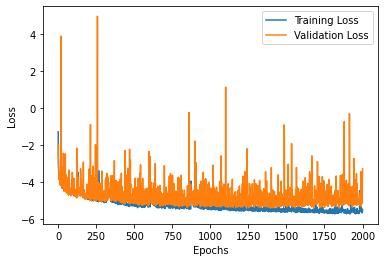

157/157 [==============================] - 7s 44ms/step - loss: -3.6558


157/157 [==============================] - 8s 45ms/step - loss: -5.5533


-5.553305625915527

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from LSTMutils import MeanVarianceLogLikelyhoodLoss

np.random.seed(42)
tf.random.set_seed(42)

SequenceLength = 250
validation_split = 0.1
batch_size = 64
NumEpochs = 2000

df = pd.read_csv(r"../TrainingData/SimulatedTrainingSet10000.csv",sep=',',header=0)

labels = df.iloc[:,0]
df_data = df.iloc[:,1:]

df_train, df_val = train_test_split(df_data, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)
df_norm_val = (df_val - min_value)/(max_value - min_value)
    
X_train = df_norm_train.iloc[:,:SequenceLength].values
y_train = df_norm_train.iloc[:,SequenceLength-1].values
X_train = np.expand_dims(X_train, 2)
y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
y_train = np.expand_dims(y_train, 2)

X_val = df_norm_val.iloc[:,:SequenceLength].values
y_val = df_norm_val.iloc[:,SequenceLength-1].values
X_val = np.expand_dims(X_val, 2)
y_val = np.broadcast_to(y_val[:,None], (y_val.shape[0],SequenceLength))
y_val = np.expand_dims(y_val, 2)

model = keras.models.Sequential([keras.layers.LSTM(50, input_shape=(SequenceLength,1), return_sequences=True, stateful=False)
                                 , keras.layers.LSTM(200, return_sequences=True, stateful=False)
                                 , keras.layers.LSTM(50, return_sequences=True, stateful=False)
                                 , keras.layers.LSTM(10, return_sequences=True, stateful=False)
                                 , keras.layers.LSTM(2, activation='softplus', return_sequences=True, stateful=False)])

checkpoint_filepath = r"../Models/SimulatedDataPretrainedModel"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer="adam",loss = MeanVarianceLogLikelyhoodLoss)

history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val,y_val), epochs=NumEpochs, callbacks=[model_checkpoint_callback,keras.callbacks.TerminateOnNaN()])

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

model.evaluate(X_train,y_train,batch_size=batch_size) #min loss shold be -6.908

bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
bestModel.evaluate(X_train, y_train, batch_size=batch_size)